In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split,Subset


import os
import random
import requests
import shutil
import itertools
import numpy as np
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
#-- Animnals --
class Animals:
    translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
                 "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
    fliped_translate = {value: key for key, value in translate.items()}
    classes = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider']

In [3]:
#-- Configuration settings ---
class CFG:
    image_path = "/kaggle/input/animals10/raw-img"
    working_path = "/kaggle/working/"
    seen_classes = Animals.classes[:8] 
    unseen_classes = Animals.classes[8:] 
    batch_size = 32
    num_workers = 2
    epochs = 20  # Adjust as needed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Training hyperparameters
    image_encoder_lr = 1e-4
    head_lr = 1e-3
    weight_decay = 1e-3
    patience = 2
    factor = 0.8

    # Image transforms
    image_size = 224
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [4]:
class AnimalDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.class_to_index = {class_name: idx for idx, class_name in enumerate(Animals.classes)}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.class_to_index[self.labels[idx]]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
#--- Image Model --- 
class ImageEncoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.classifier[-1].parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_recalls = []
    val_recalls = []
    train_precisions = []
    val_precisions = []
    no_improvement = 0
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in tqdm(range(num_epochs), desc='Epoch', total=num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        true_train = []
        pred_train = []
        for inputs, labels in tqdm(train_loader, desc='Training', total=len(train_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            true_train.extend(labels.cpu().numpy())
            pred_train.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = accuracy_score(true_train, pred_train)
        train_accuracies.append(train_accuracy)
        train_precision = precision_score(true_train, pred_train, average='macro')
        train_precisions.append(train_precision)
        train_recall = recall_score(true_train, pred_train, average='macro')
        train_recalls.append(train_recall)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        true_val = []
        pred_val = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation', total=len(val_loader)):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                true_val.extend(labels.cpu().numpy())
                pred_val.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = accuracy_score(true_val, pred_val)
        val_accuracies.append(val_accuracy)
        val_precision = precision_score(true_val, pred_val, average='macro')
        val_precisions.append(val_precision)
        val_recall = recall_score(true_val, pred_val, average='macro')
        val_recalls.append(val_recall)
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= CFG.patience:
            print(f'Validation loss did not improve for {CFG.patience} epochs. Stopping training.')
            break

    # After the loop, load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}')
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
    }

    return model, metrics

In [7]:
def test_model(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', total=len(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = accuracy_score(true_labels, pred_labels)
    test_precision = precision_score(true_labels, pred_labels, average='macro')
    test_recall = recall_score(true_labels, pred_labels, average='macro')

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'true_labels': true_labels,
        'pred_labels': pred_labels,
    }

In [8]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_losses']) + 1)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Train Loss')
    plt.plot(epochs, metrics['val_losses'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train_accuracies'], label='Train Acc')
    plt.plot(epochs, metrics['val_accuracies'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['train_precisions'], label='Train Precision')
    plt.plot(epochs, metrics['val_precisions'], label='Val Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['train_recalls'], label='Train Recall')
    plt.plot(epochs, metrics['val_recalls'], label='Val Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
# Create a dictionary to map class names to file paths
class_to_files = defaultdict(list)
for class_name in Animals.translate.values():
    class_dir = os.path.join(CFG.image_path, Animals.fliped_translate[class_name])
    class_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)]
    class_to_files[class_name].extend(class_files)

In [10]:
# Assign file paths and labels for seen and unseen classes
seen_file_paths = []
seen_labels = []
unseen_file_paths = []
unseen_labels = []
for class_name, files in class_to_files.items():
    if class_name in CFG.seen_classes:
        seen_file_paths.extend(files)
        seen_labels.extend([class_name] * len(files))
    else:
        unseen_file_paths.extend(files)
        unseen_labels.extend([class_name] * len(files))

In [11]:
# Define datasets for seen and unseen classes
seen_dataset = AnimalDataset(seen_file_paths, seen_labels, transform=CFG.preprocess)
unseen_dataset = AnimalDataset(unseen_file_paths, unseen_labels, transform=CFG.preprocess)

In [12]:
# Create DataLoader for training and validation from seen_dataset
num_train = int(len(seen_dataset) * 0.6)
num_val = int(len(seen_dataset) * 0.2)
num_test = len(seen_dataset) - num_train - num_val

train_dataset, val_dataset, seen_test_dataset = random_split(seen_dataset, [num_train, num_val, num_test])

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

# Create DataLoader for testing from seen_test_dataset
seen_test_loader = DataLoader(seen_test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

# Create DataLoader for testing from unseen_dataset
test_loader = DataLoader(unseen_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

In [13]:
# Define and instantiate your ImageEncoder model
model = ImageEncoder(num_classes=len(Animals.classes)).to(CFG.device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]


In [14]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.image_encoder_lr, weight_decay=CFG.weight_decay)
# Define your loss function
criterion = nn.CrossEntropyLoss()

In [15]:
# Train the model
trained_model, metrics = train_model(model, criterion, optimizer, train_loader, val_loader, CFG.device, num_epochs=CFG.epochs)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Training:   0%|          | 0/366 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Validation loss did not improve for 2 epochs. Stopping training.
Epoch 15/20, Train Loss: 0.1135, Train Acc: 0.9632, Train Precision: 0.9610, Train Recall: 0.9597, Val Loss: 0.1200, Val Acc: 0.9610, Val Precision: 0.9572, Val Recall: 0.9576


In [16]:
# Evaluate the model on the test set
test_results = test_model(trained_model, criterion, seen_test_loader, CFG.device)

Testing:   0%|          | 0/122 [00:00<?, ?it/s]

Test Loss: 0.1268, Test Acc: 0.9623, Test Precision: 0.9593, Test Recall: 0.9612


In [17]:
# Evaluate the model on the test set
test_results = test_model(trained_model, criterion, test_loader, CFG.device)

Testing:   0%|          | 0/209 [00:00<?, ?it/s]

Test Loss: 8.6551, Test Acc: 0.0000, Test Precision: 0.0000, Test Recall: 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


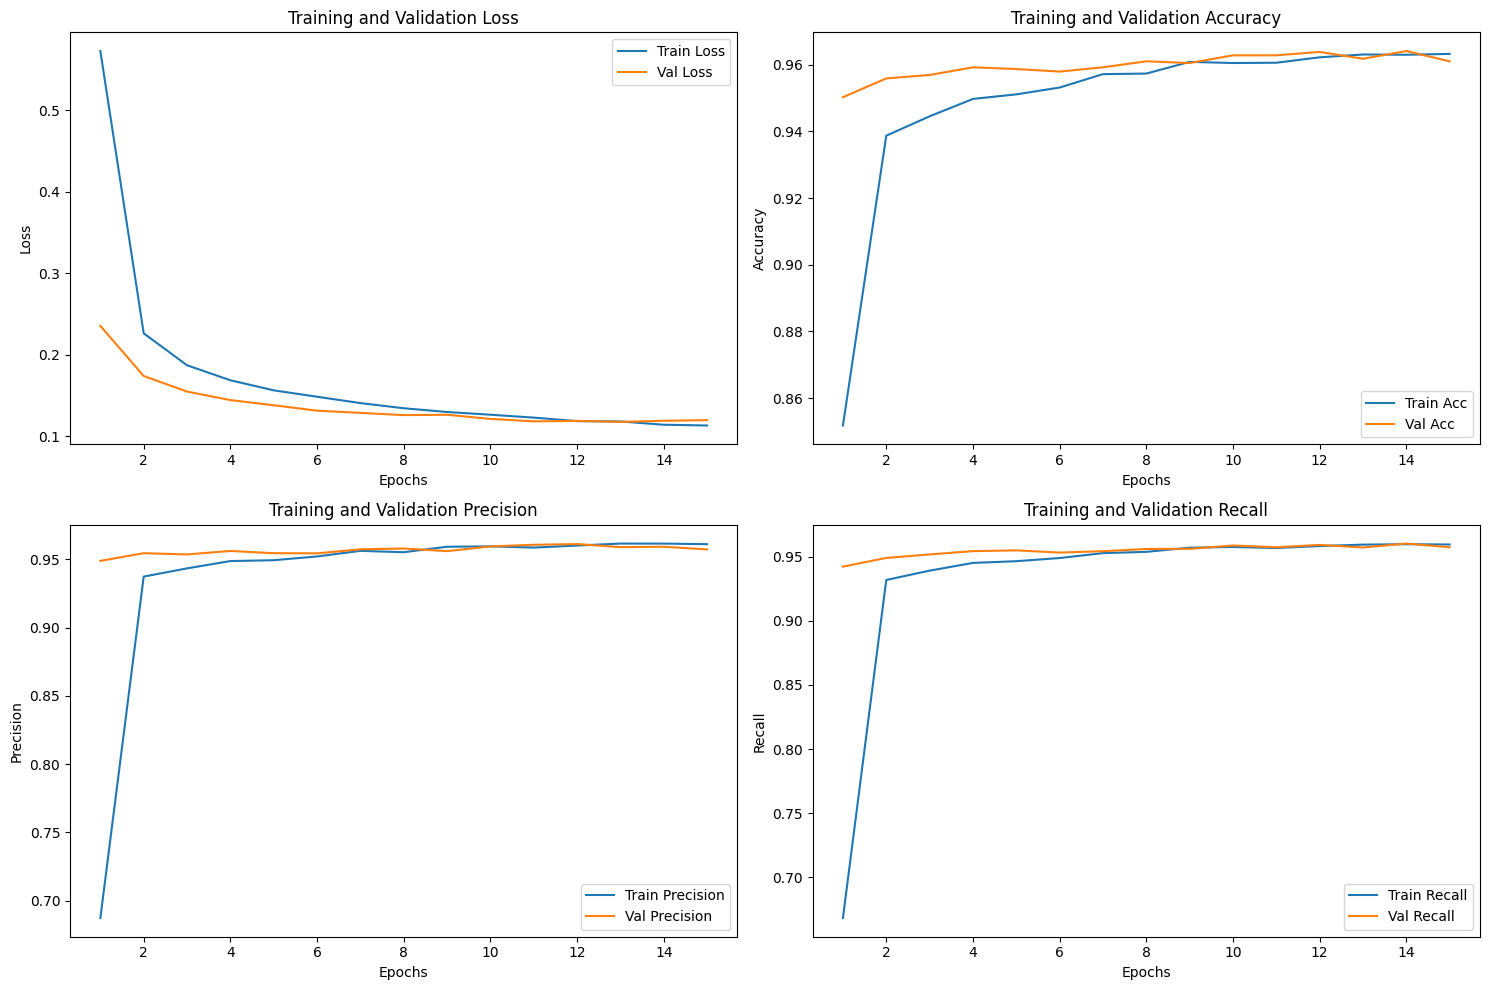

In [18]:
# Plot metrics
plot_metrics(metrics)